In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, RFE, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from matplotlib.ticker import MultipleLocator
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [7]:
train_data = pd.read_csv("C:\\Users\\fongr\\Documents\\Мои документы\\Второй курс\\python\\scientificProject1\\data\\train.csv")
test_data = pd.read_csv("C:\\Users\\fongr\\Documents\\Мои документы\\Второй курс\\python\\scientificProject1\\data\\test.csv")

In [8]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229292 entries, 0 to 229291
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    229292 non-null  int64  
 1   Gender                229292 non-null  object 
 2   Age                   229292 non-null  int64  
 3   Driving_License       229292 non-null  int64  
 4   Region_Code           229292 non-null  float64
 5   Previously_Insured    229292 non-null  int64  
 6   Vehicle_Age           229292 non-null  object 
 7   Vehicle_Damage        229292 non-null  object 
 8   Annual_Premium        229292 non-null  float64
 9   Policy_Sales_Channel  229292 non-null  float64
 10  Vintage               229292 non-null  int64  
 11  Response              229292 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 21.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152862 entries, 0 to 152861
Data columns (total 

Из info видно, что ни в одном столбце нет пустых значений. Выполним деление на числовые и категориальные признаки

In [9]:
df_cat = ["Gender", "Vehicle_Age", "Vehicle_Damage"]
df_num = ["Age", "Driving_License", "Previously_Insured", "Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]
df_all = df_num + df_cat
result_col = "Response"
train_data.drop("id", axis=1, inplace=True)

In [10]:
for col in df_cat:
    print(train_data[col].unique())

['Male' 'Female']
['1-2 Year' '< 1 Year' '> 2 Years']
['No' 'Yes']


In [11]:
for col in df_num:
    print(train_data[col].describe())

count    229292.000000
mean         38.554987
std          15.231658
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64
count    229292.000000
mean          0.998138
std           0.043114
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Driving_License, dtype: float64
count    229292.000000
mean          0.489062
std           0.499881
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: Previously_Insured, dtype: float64
count    229292.000000
mean         26.420207
std          13.191474
min           0.000000
25%          15.000000
50%          28.000000
75%          35.000000
max          52.000000
Name: Region_Code, dtype: float64
count    229292.000000
mean      30730.076549
std       17054.686028
min        2630.000000
25%       24564.000000
50%       

Произведём кодирование категориальных признаков

In [12]:
le = LabelEncoder()
for column in df_cat:
    train_data[column] = le.fit_transform(train_data[column])
    test_data[column] = le.fit_transform(test_data[column])
    train_data[column] = train_data[column].astype("category")
    test_data[column] = test_data[column].astype("category")
    print(train_data[column].unique())

[1, 0]
Categories (2, int64): [0, 1]
[0, 1, 2]
Categories (3, int64): [0, 1, 2]
[0, 1]
Categories (2, int64): [0, 1]


Произведём нормирование всех числовых признаков

In [13]:
scaler = MinMaxScaler()
train_data[df_num] = scaler.fit_transform(train_data[df_num])
test_data[df_num] = scaler.fit_transform(test_data[df_num])
train_data.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,229292.000000,229292.000000,229292.000000,229292.000000,229292.000000,229292.000000,229292.000000,229292.000000
mean,0.285461,0.998138,0.508081,0.489062,0.052276,0.684714,0.498943,0.164079
std,0.234333,0.043114,0.253682,0.499881,0.031728,0.335236,0.289713,0.370348
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.076923,1.000000,0.288462,0.000000,0.040805,0.154321,0.249135,0.000000
50%,0.246154,1.000000,0.538462,0.000000,0.054097,0.858025,0.498270,0.000000
75%,0.446154,1.000000,0.673077,1.000000,0.068535,0.932099,0.750865,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Отбор информативных признаков

In [14]:
x = train_data[df_all]
y = train_data[result_col]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)
masks = scoring = tuple()
n_features_select = 5

### Метод фильтрации

In [15]:
skb = SelectKBest(k=n_features_select)
top = skb.fit(x, y)
selected_features_mutual_info = top.get_feature_names_out()
print(selected_features_mutual_info)

['Age' 'Previously_Insured' 'Policy_Sales_Channel' 'Vehicle_Age'
 'Vehicle_Damage']


### Метод обёртки

In [16]:
clf = LinearRegression()
rfe = RFE(clf, n_features_to_select=n_features_select, step=1)
top_five = rfe.fit(x, y)
selected_features_RFE = top_five.get_feature_names_out()
print(selected_features_RFE)

['Driving_License' 'Previously_Insured' 'Annual_Premium'
 'Policy_Sales_Channel' 'Vehicle_Damage']


### Встроенные методы

In [17]:
selector = SelectKBest(chi2, k=n_features_select)
selector.fit_transform(x, y)
selected_features_chi2 = selector.get_feature_names_out()
print(selected_features_chi2)

['Age' 'Previously_Insured' 'Policy_Sales_Channel' 'Vehicle_Age'
 'Vehicle_Damage']


### Сравнение результатов

In [18]:
selected_dict = {
    "chi2": skb,
    "rfe": rfe,
    "mutual_inf": selector,
}

Подсчёт score для изначального фрейма

In [19]:
model = GaussianNB().fit(x_train, y_train)
masks += ([True for _ in range(x_train.shape[1])],)
scoring += (roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]),)
print("Score (ROC-AUC): " + str(scoring[-1]))

Score (ROC-AUC): 0.8644920774756426


In [20]:
for selector_name, selector in selected_dict.items():
    model = GaussianNB().fit(selector.transform(x_train), y_train)
    masks += (selector.get_support(),)
    scoring = (roc_auc_score(y_test, model.predict_proba(selector.transform(x_test))[:, 1]),)
    print("Score (ROC-AUC): " + str(scoring[-1]))

Score (ROC-AUC): 0.8636157626498
Score (ROC-AUC): 0.8459675143247214
Score (ROC-AUC): 0.8636157626498


Можно увидеть, что 1 и 3 методы выбора значимых признаков дали наилучший результат
### Удаление незначимых признаков

In [21]:
selected_features = selected_features_mutual_info
train_data = train_data.loc[:, np.append(selected_features, result_col)]
test_data = test_data.loc[:, selected_features]
df_all = selected_features

x = train_data[df_all]
y = train_data[result_col]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229292 entries, 0 to 229291
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Age                   229292 non-null  float64 
 1   Previously_Insured    229292 non-null  float64 
 2   Policy_Sales_Channel  229292 non-null  float64 
 3   Vehicle_Age           229292 non-null  category
 4   Vehicle_Damage        229292 non-null  category
 5   Response              229292 non-null  int64   
dtypes: category(2), float64(3), int64(1)
memory usage: 7.4 MB


## Сэмплирование данных

In [22]:
sampling = ((x, y), RandomOverSampler().fit_resample(x, y), RandomUnderSampler().fit_resample(x, y))
scoring = tuple()
print("Score (ROC-AUC):")
for sx, sy in sampling:
    scoring += (round(max(cross_val_score(GaussianNB(), sx, sy, scoring="roc_auc", n_jobs=-1)), 3),)
    print(scoring[-1])

Score (ROC-AUC):
0.866
0.864
0.867


Наилучшим оказался набор, полученный с помощью under-sampling

In [23]:
x, y = sampling[scoring.index(max(scoring))]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)

## Построение моделей

In [24]:
def create_train_model(clf, param_grid: dict[str]={}) -> GridSearchCV:
    print("Started creation")
    """Создать и обучить модель с подбором параметров."""
    new_model = GridSearchCV(clf, param_grid, n_jobs=-1, scoring="roc_auc").fit(x_train, y_train)
    if param_grid:
        print(new_model.best_estimator_)
    print("Score (ROC_AUC): " + str(round(model.score(x_test, y_test), 6)))
    return new_model


### Логистическая регрессия

In [25]:
param_grid = {
    "penalty": ["l1", "l2"],
    "solver": ["saga", "liblinear"],
    "max_iter": range(1, 10)}

lg = create_train_model(LogisticRegression(), param_grid)

Started creation
LogisticRegression(max_iter=6, penalty='l1', solver='saga')
Score (ROC_AUC): 0.815939


C:\Users\fongr\anaconda3\envs\scientificProject1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\fongr\anaconda3\envs\scientificProject1\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


### Метод KNN

In [26]:
param_grid = {
    "n_neighbors": range(15, 20),
    "weights": ["uniform", "distance"]
}

knc = create_train_model(KNeighborsClassifier(), param_grid)

Started creation
KNeighborsClassifier(n_neighbors=19)
Score (ROC_AUC): 0.815939


C:\Users\fongr\anaconda3\envs\scientificProject1\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


### Наивный байесовский классификатор

In [27]:
params = {'var_smoothing': [1e-9, 1e-5, 1e-2, 0.1, 1]}
gnb = create_train_model(GaussianNB(), params)

Started creation
GaussianNB()
Score (ROC_AUC): 0.815939


C:\Users\fongr\anaconda3\envs\scientificProject1\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


### Линейный дискриминантный анализ

In [28]:
params = {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.5, 0.9]}
lda = create_train_model(LinearDiscriminantAnalysis(), params)

Started creation
LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')
Score (ROC_AUC): 0.815939


C:\Users\fongr\anaconda3\envs\scientificProject1\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


### Квадратичный дискриминантный анализ

In [29]:
params =  {'store_covariance': [True, False], 'reg_param': [0, 0.1, 0.25, 0.5, 0.7, 1]}
qda = create_train_model(QuadraticDiscriminantAnalysis(), params)

Started creation
QuadraticDiscriminantAnalysis(reg_param=0, store_covariance=True)
Score (ROC_AUC): 0.815939


C:\Users\fongr\anaconda3\envs\scientificProject1\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


### Метод опорных векторов

In [30]:
params = {'max_iter': range(1, 10)}
# svc = create_train_model(SVC(probability=True))

### Построение ROC кривых и столбчатой диаграммы score

In [31]:
models = (lg, knc, gnb, lda, qda)
names = scoring = probs = tuple()
for model in models:
    names += (model.best_estimator_.__class__.__name__,)
    scoring += (round(model.score(x_test, y_test), 3),)
    probs += (model.predict_proba(x_test)[:, 1],)

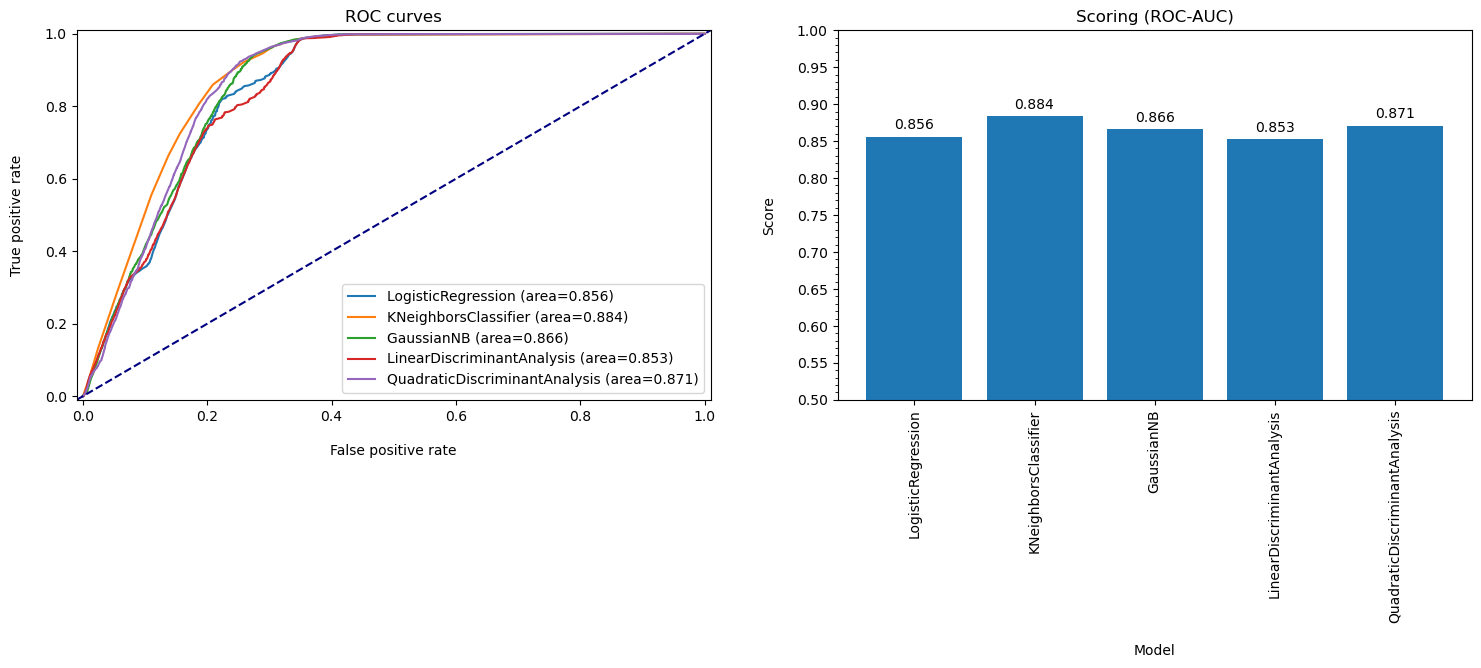

In [32]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(18)

labels = tuple()
for i, prob in enumerate(probs):
    fpr, tpr, _ = roc_curve(y_test, prob)
    area = round(auc(fpr, tpr), 3)
    labels += (names[i] + f" ({area=})",)
    axes[0].plot(fpr, tpr)
axes[0].plot((-0.01, 1.01), (-0.01, 1.01), color="navy", linestyle="--")

axes[0].set_title("ROC curves")
axes[0].set_xlim((-0.01, 1.01))
axes[0].set_ylim((-0.01, 1.01))

axes[0].set_xlabel("False positive rate", labelpad=15)
axes[0].set_ylabel("True positive rate", labelpad=15)
axes[0].legend(loc="lower right", labels=labels)

axes[1].bar(names, scoring)
axes[1].set_title("Scoring (ROC-AUC)")
axes[1].tick_params("x", labelrotation=90)

axes[1].set_ylim((0.5, 1))
axes[1].yaxis.set_major_locator(MultipleLocator(0.05))
axes[1].yaxis.set_minor_locator(MultipleLocator(0.01))
for rect, score in zip(axes[1].patches, scoring):
    axes[1].text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.01, score, ha="center")

axes[1].set_xlabel("Model", labelpad=15)
axes[1].set_ylabel("Score", labelpad=15)
plt.show()

In [38]:
best_model = models[scoring.index(max(scoring))]
print("В результате анализа была выбрана следующая модель: " + str(best_model.best_estimator_))

В результате анализа была выбрана следующая модель: KNeighborsClassifier(n_neighbors=19)


## Работа с тестовой выборкой